<a href="https://colab.research.google.com/github/TatianaZhandarova/learning_projects/blob/main/3_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Аналитическая задача** — провести анализ данных с целью выделения портретов заемщиков по каждой группе целевого признака.

**Примерный план исследования**

Шаг 1. Загрузка данных;

Шаг 2. Первичная обработка данных (при необходимости):
- скорректировать заголовки;
- скорректировать типы признаков;
- проверить наличие дублирующихся записей;
- проверить наличие аномальных значений;
- восстановить пропущенные значения;

Шаг 3. Добавление новых признаков:
- для каждого клиента рассчитайте его возраст на настоящий момент времени (на 2025 год);

Шаг 4. Исследовательский анализ данных
- в разрезе значений целевого признака (`Дисциплина клиентов без просрочки по кредиту`) исследовать распределения числовых и категориальных признаков;
- в разрезе значений целевого признака составить портреты клиентов платежной системы.

In [ ]:
# что бы использовать SQL-запросы к DataFrame
!pip install pandasql

  Preparing metadata (setup.py) ... done
  Created wheel for pandasql: filename=pandasql-0.7.3-py3-none-any.whl size=26773 sha256=01a4e25f80256e85cb5e6bcc6a504cee9cb7b99dcf8d89447221803a3c547c88
  Stored in directory: /root/.cache/pip/wheels/15/a1/e7/6f92f295b5272ae5c02365e6b8fa19cb93f16a537090a1cf27
Successfully built pandasql


In [ ]:
# подключение библиотек
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import sqlite3
from pandasql import sqldf

In [ ]:
# 2 линии нижнего и верхнего усов
#для подсчета значений нижнего и верхнего усов была предложена следующая функция
def calc_boxplot(df_col : pd.Series) -> tuple:

    """
    Функция для расчета значений нижнего и верхнего усов.
    На вход подается столбец датафрейма,
    на выходе кортеж: первый элемент -- нижний ус, второй элемент -- верхний ус
    """

    Q1, median, Q3 = np.percentile(np.asarray(df_col.dropna()), [25, 50, 75])
    IQR = Q3 - Q1
    loval = Q1 - 1.5 * IQR
    hival = Q3 + 1.5 * IQR
    wiskhi = np.compress(np.asarray(df_col.dropna()) <= hival, np.asarray(df_col.dropna()))
    wisklo = np.compress(np.asarray(df_col.dropna()) >= loval, np.asarray(df_col.dropna()))
    actual_hival = np.max(wiskhi)
    actual_loval = np.min(wisklo)
    return actual_loval, actual_hival #(нижний ус, верхний ус)

In [ ]:
# загрузка данных
df = pd.read_csv('/content/dataset_segment_bank_project_3.csv')
df.head()

,Идентификатор,Дата рождения,Дисциплина клиентов без просрочки по кредиту,Количество переводов,Тип переводов,География переводов,География телефона,Сумма перевода,Максимальная сумма перевода,Средняя сумма перевода,Полная сумма перевода,"Канал, через который пришел клиент",Оператор связи,Пол
0,1493553,1981-05-08,BAD,17.0,2.0,77.0,77.0,371600.00,265000.0,21858.8235,371600.00,Стойка,NaN,Ж
1,8130758,1979-03-06,BAD,4.0,2.0,77.0,77.0,137574.00,135000.0,34393.5000,137574.00,Стойка,NaN,М
2,1782539,1957-04-29,BAD,3.0,2.0,77.0,77.0,175150.00,135000.0,58383.3333,175150.00,Стойка,МегаФон,М
3,12410720,1977-08-05,BAD,3.0,2.0,77.0,77.0,50250.00,50000.0,16750.0000,50250.00,Стойка,NaN,М
4,21309736,1978-08-15,GOOD,5.0,69.0,77.0,77.0,215920.14,135000.0,43184.0280,215920.14,Стойка,NaN,М


In [ ]:
df.columns

Index(['Идентификатор', 'Дата рождения',
       'Дисциплина клиентов без просрочки по кредиту', 'Количество переводов',
       'Тип переводов', 'География переводов', 'География телефона',
       'Сумма перевода', 'Максимальная сумма перевода',
       'Средняя сумма перевода', 'Полная сумма перевода',
       'Канал, через который пришел клиент', 'Оператор связи', 'Пол'],
      dtype='object')

In [ ]:
# информация о типах данных
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50224 entries, 0 to 50223
Data columns (total 14 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   Идентификатор                                 50224 non-null  int64  
 1   Дата рождения                                 50224 non-null  object 
 2   Дисциплина клиентов без просрочки по кредиту  50223 non-null  object 
 3   Количество переводов                          50158 non-null  float64
 4   Тип переводов                                 50191 non-null  float64
 5   География переводов                           50191 non-null  float64
 6   География телефона                            48324 non-null  float64
 7   Сумма перевода                                50158 non-null  float64
 8   Максимальная сумма перевода                   50158 non-null  float64
 9   Средняя сумма перевода                        50158 non-null 

In [ ]:
# проверка наличия дублей
df.duplicated().sum()

np.int64(575)

In [ ]:
# просмотр дублей
df[df.duplicated(keep=False)].sort_values(by=df.columns.tolist())

,Идентификатор,Дата рождения,Дисциплина клиентов без просрочки по кредиту,Количество переводов,Тип переводов,География переводов,География телефона,Сумма перевода,Максимальная сумма перевода,Средняя сумма перевода,Полная сумма перевода,"Канал, через который пришел клиент",Оператор связи,Пол
22825,1415267,1955-03-15,MIDDLE,89.0,2.0,77.0,77.0,326550.00,135000.0,3669.1011,326550.00,Офис,МегаФон,Ж
22826,1415267,1955-03-15,MIDDLE,89.0,2.0,77.0,77.0,326550.00,135000.0,3669.1011,326550.00,Офис,МегаФон,Ж
22280,1438822,1951-01-01,GOOD,11.0,2.0,77.0,77.0,90325.00,40000.0,8211.3636,90325.00,Офис,Мобильные ТелеСистемы,М
22321,1438822,1951-01-01,GOOD,11.0,2.0,77.0,77.0,90325.00,40000.0,8211.3636,90325.00,Офис,Мобильные ТелеСистемы,М
48050,1508526,1965-08-20,GOOD,65.0,2.0,77.0,77.0,639530.00,100000.0,9838.9230,639530.00,Офис,МегаФон,М
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23166,25318127,1974-11-07,MIDDLE,5.0,69.0,61.0,NaN,216400.00,130000.0,43280.0000,216400.00,Офис,Мобильные ТелеСистемы,Ж
23298,25318127,1974-11-07,MIDDLE,5.0,69.0,61.0,NaN,216400.00,130000.0,43280.0000,216400.00,Офис,Мобильные ТелеСистемы,Ж
1000,25928253,1983-10-22,MIDDLE,30.0,2.0,77.0,NaN,205245.76,50000.0,6841.5253,205245.76,Партнер,Мобильные ТелеСистемы,М
1046,25928253,1983-10-22,MIDDLE,30.0,2.0,77.0,NaN,205245.76,50000.0,6841.5253,205245.76,Партнер,Мобильные ТелеСистемы,М


In [ ]:
# удаление дублей с оставлением первого вхождения
df.drop_duplicates(keep='first', inplace=True)

In [ ]:
# описательные статистики
per = [0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95]
df.describe(percentiles=per)

,Идентификатор,Количество переводов,Тип переводов,География переводов,География телефона,Сумма перевода,Максимальная сумма перевода,Средняя сумма перевода,Полная сумма перевода
count,4.964900e+04,49583.000000,49616.000000,49616.000000,47781.000000,4.958300e+04,4.958300e+04,49583.000000,4.958300e+04
mean,1.097182e+07,15.886130,13.224484,110.669744,58.206735,2.943397e+05,1.680532e+05,34735.108103,2.943397e+05
std,5.763481e+06,29.672765,22.350063,4998.489682,22.707858,4.486187e+05,1.408856e+05,43694.270643,4.486187e+05
min,1.400402e+06,1.000000,-1.000000,0.000000,0.000000,3.000000e+01,3.000000e+01,30.000000,3.000000e+01
1%,1.552769e+06,1.000000,0.000000,2.000000,2.000000,2.353525e+04,1.488524e+04,2360.318008,2.353525e+04
5%,2.226812e+06,2.000000,2.000000,13.000000,10.000000,3.993920e+04,3.000000e+04,4540.988570,3.993920e+04
10%,3.216368e+06,2.000000,2.000000,23.000000,23.000000,5.340790e+04,4.000000e+04,6105.593080,5.340790e+04
25%,6.377852e+06,4.000000,2.000000,48.000000,42.000000,9.137250e+04,5.500000e+04,10254.507200,9.137250e+04
50%,1.134104e+07,9.000000,5.000000,73.000000,66.000000,1.857500e+05,1.200000e+05,20049.153800,1.857500e+05
75%,1.444320e+07,17.000000,6.000000,77.000000,77.000000,3.759768e+05,2.350000e+05,41927.295450,3.759768e+05


In [ ]:
# корректировка типов данных
df = df.astype({'Дата рождения' : 'datetime64[ms]'})

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 49649 entries, 0 to 50223
Data columns (total 14 columns):
 #   Column                                        Non-Null Count  Dtype         
---  ------                                        --------------  -----         
 0   Идентификатор                                 49649 non-null  int64         
 1   Дата рождения                                 49649 non-null  datetime64[ms]
 2   Дисциплина клиентов без просрочки по кредиту  49648 non-null  object        
 3   Количество переводов                          49583 non-null  float64       
 4   Тип переводов                                 49616 non-null  float64       
 5   География переводов                           49616 non-null  float64       
 6   География телефона                            47781 non-null  float64       
 7   Сумма перевода                                49583 non-null  float64       
 8   Максимальная сумма перевода                   49583 non-null  float64  

In [ ]:
# подсчет пропущенных значений
missing_values = df.isnull().sum().sort_values(ascending=False)
missing_values

,0
География телефона,1868
Оператор связи,644
Сумма перевода,66
Максимальная сумма перевода,66
Количество переводов,66
Средняя сумма перевода,66
Полная сумма перевода,66
Тип переводов,33
География переводов,33
"Канал, через который пришел клиент",31


In [ ]:
# Заполнение пропущенных значений

# Для категориальных признаков заполним модой
for col in ['Дисциплина клиентов без просрочки по кредиту', 'Канал, через который пришел клиент', 'Оператор связи', 'Пол']:
    if df[col].isnull().any():
        df[col].fillna(df[col].mode()[0], inplace=True)

# Для числовых признаков заполним медианой
for col in ['Количество переводов', 'Тип переводов', 'География переводов', 'География телефона', 'Сумма перевода', 'Максимальная сумма перевода', 'Средняя сумма перевода', 'Полная сумма перевода']:
    if df[col].isnull().any():
        df[col].fillna(df[col].median(), inplace=True)

# Проверим, остались ли пропущенные значения
display(df.isnull().sum().sort_values(ascending=False))

/tmp/ipython-input-676526551.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].mode()[0], inplace=True)
/tmp/ipython-input-676526551.py:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try usin

,0
Идентификатор,0
Дата рождения,0
Дисциплина клиентов без просрочки по кредиту,0
Количество переводов,0
Тип переводов,0
География переводов,0
География телефона,0
Сумма перевода,0
Максимальная сумма перевода,0
Средняя сумма перевода,0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 49649 entries, 0 to 50223
Data columns (total 14 columns):
 #   Column                                        Non-Null Count  Dtype         
---  ------                                        --------------  -----         
 0   Идентификатор                                 49649 non-null  int64         
 1   Дата рождения                                 49649 non-null  datetime64[ms]
 2   Дисциплина клиентов без просрочки по кредиту  49649 non-null  object        
 3   Количество переводов                          49649 non-null  float64       
 4   Тип переводов                                 49649 non-null  float64       
 5   География переводов                           49649 non-null  float64       
 6   География телефона                            49649 non-null  float64       
 7   Сумма перевода                                49649 non-null  float64       
 8   Максимальная сумма перевода                   49649 non-null  float64  

In [ ]:
list_columns = [
    'Количество переводов',
    'Тип переводов',
    'Сумма перевода',
    'Максимальная сумма перевода',
    'Средняя сумма перевода',
    'Полная сумма перевода'
]
len(list_columns)

6

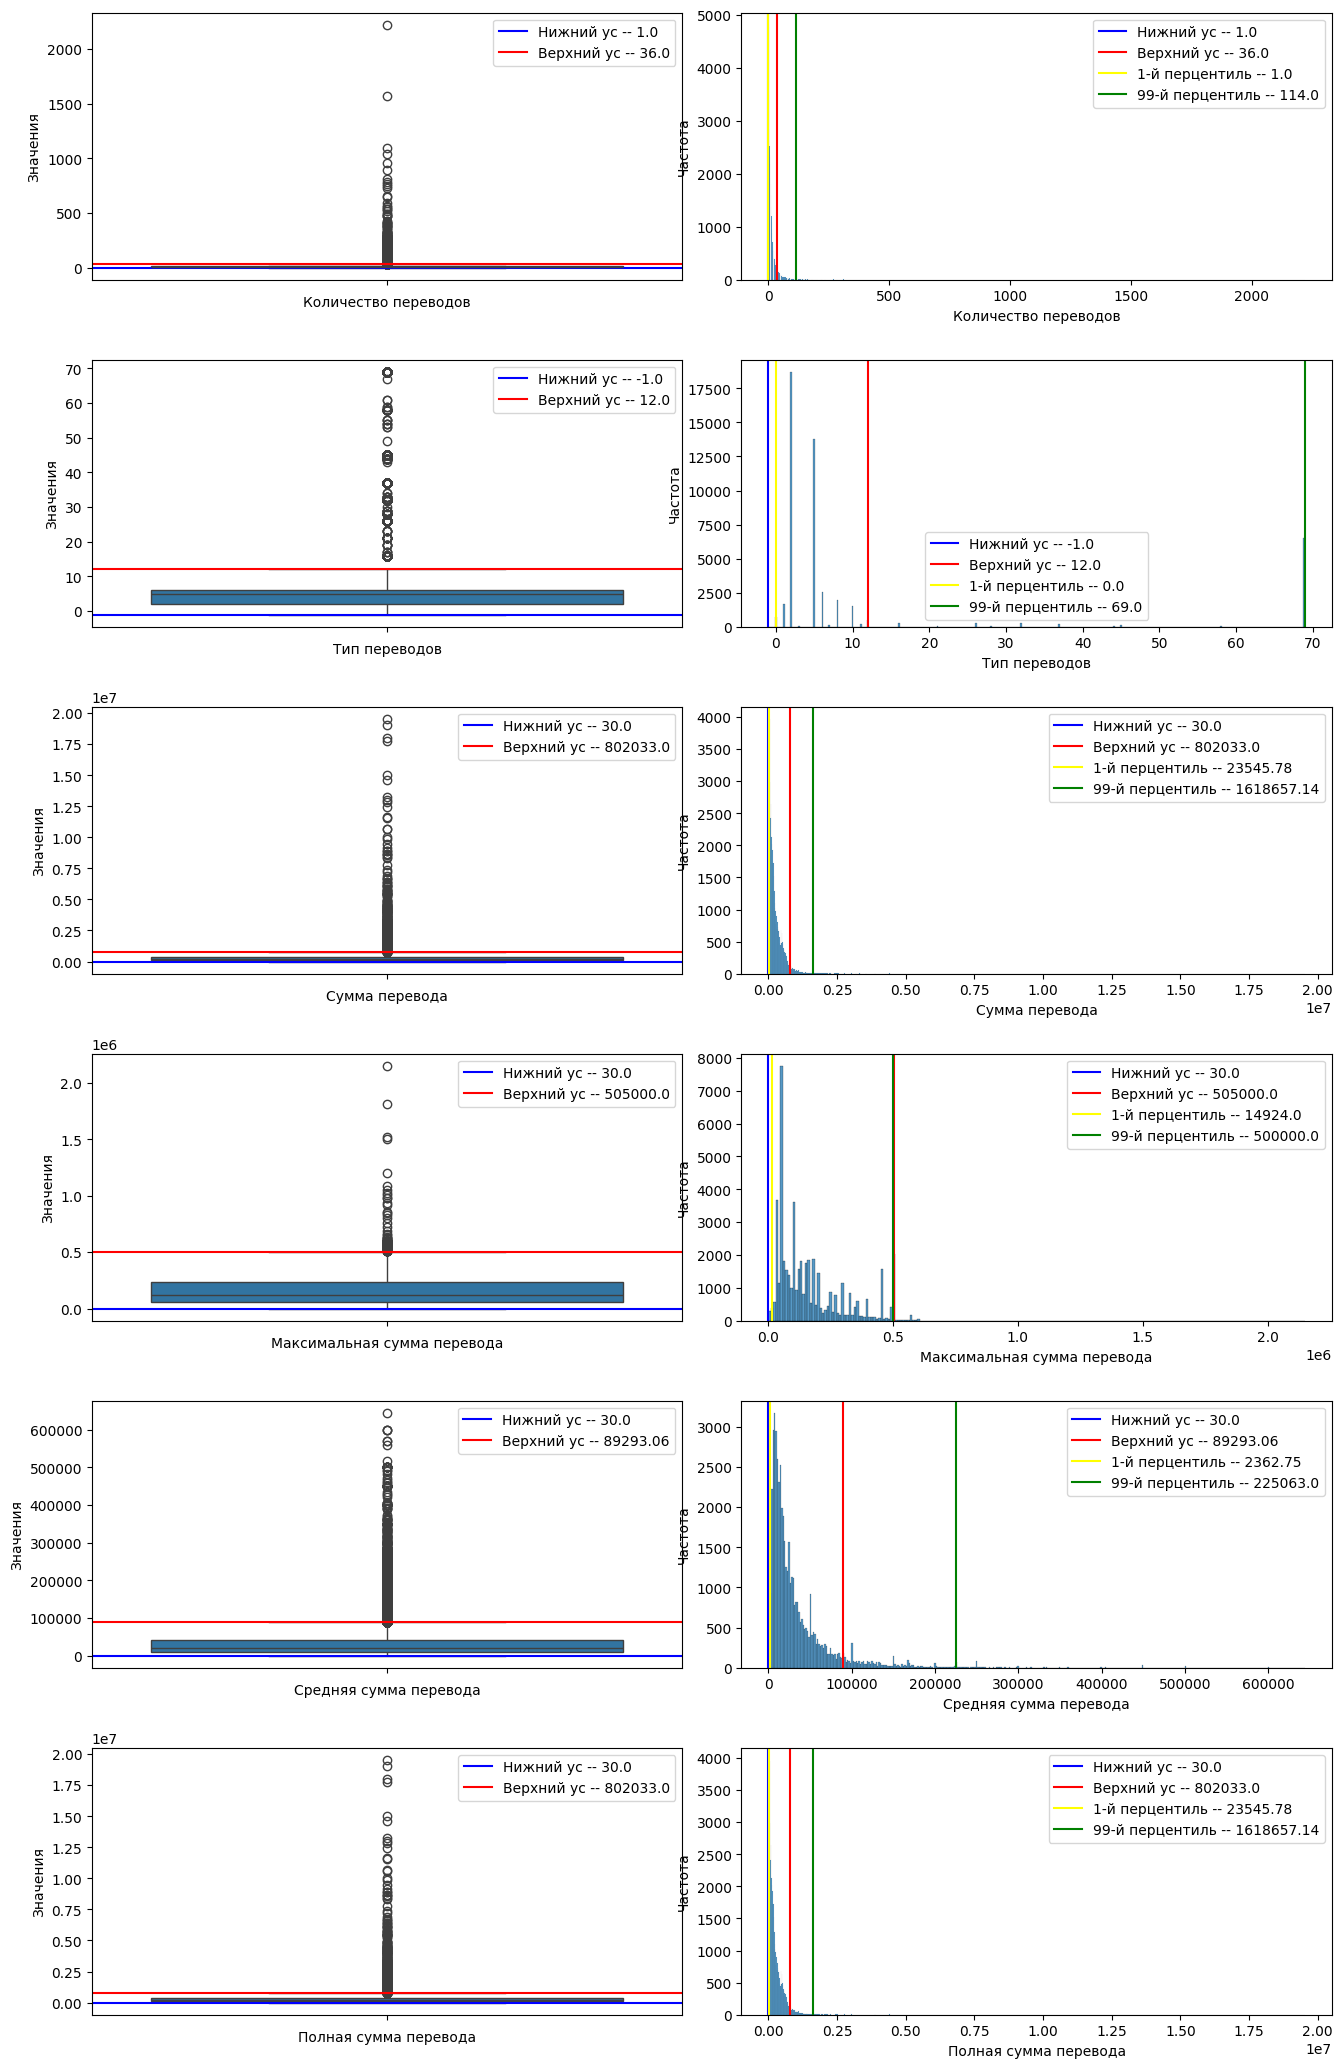

In [ ]:
# для выявления аномальных значений признака
# воспользуемся графиком boxplot (ящик с усами) и гистограммой

# для каждого признака по 2 графика

fig, ax = plt.subplots(6,2, figsize=(16,26), gridspec_kw={"wspace": 0.1,
                                                          "hspace": 0.3})

for index, col in enumerate(list_columns[:]):
    plt.subplot(6,2, 2*index+1) # 2*n+1, n = 0,1,2,3,
    # расчет значений нижнего и верхнего уса
    low_value, high_value = calc_boxplot(df[col])
    ax = sns.boxplot(y=df[col])
    # визуализация усов
    ax.axhline(low_value,
               color='blue',
               label=f"Нижний ус -- {np.round(low_value, 2)}")
    ax.axhline(high_value,
               color='red',
               label=f"Верхний ус -- {np.round(high_value, 2)}")
    ax.set_xlabel(f"{col}")
    ax.set_ylabel("Значения")
    plt.legend()

    plt.subplot(6,2, 2*index+2) # 2*n+2, n = 0,1,2,3,
    # расчет 1 и 99 --перцентилей
    per_1  = np.nanpercentile(df[col], 1)
    per_99 = np.nanpercentile(df[col], 99)

    ax = sns.histplot(x=df[col])

    # визуализация усов
    ax.axvline(low_value,
               color='blue',
               label=f"Нижний ус -- {np.round(low_value, 2)}")
    ax.axvline(high_value,
               color='red',
               label=f"Верхний ус -- {np.round(high_value, 2)}")

    # визуализация перцентилей
    ax.axvline(per_1,
               color='yellow',
               label=f"1-й перцентиль -- {np.round(per_1, 2)}")
    ax.axvline(per_99,
               color='green',
               label=f"99-й перцентиль -- {np.round(per_99, 2)}")
    ax.set_xlabel(f"{col}")
    ax.set_ylabel("Частота")
    plt.legend()

In [ ]:
# фильтр для отсеивания аномальных значений

continuous_cols = [
    'Количество переводов',
    'Сумма перевода', 'Максимальная сумма перевода',
    'Средняя сумма перевода', 'Полная сумма перевода'
]

cat_cols = ['Тип переводов', 'География переводов', 'География телефона']

flt = pd.Series([True] * len(df), index=df.index)

# 1. Непрерывные: 1% — 99%
for col in continuous_cols:
    flt &= df[col].between(np.nanpercentile(df[col], 1),
                           np.nanpercentile(df[col], 99))

# 2. Категориальные: только частые (>1%)
for col in cat_cols:
    freq = df[col].value_counts(normalize=True)
    flt &= df[col].isin(freq[freq >= 0.01].index)

df_clean = df[flt].reset_index(drop=True)

In [ ]:
result_1 = sqldf("""
SELECT *
from df_clean;
""")
result_1

,Идентификатор,Дата рождения,Дисциплина клиентов без просрочки по кредиту,Количество переводов,Тип переводов,География переводов,География телефона,Сумма перевода,Максимальная сумма перевода,Средняя сумма перевода,Полная сумма перевода,"Канал, через который пришел клиент",Оператор связи,Пол
0,1493553,1981-05-08 00:00:00.000000,BAD,17.0,2.0,77.0,77.0,371600.00,265000.0,21858.8235,371600.00,Стойка,МегаФон,Ж
1,8130758,1979-03-06 00:00:00.000000,BAD,4.0,2.0,77.0,77.0,137574.00,135000.0,34393.5000,137574.00,Стойка,МегаФон,М
2,1782539,1957-04-29 00:00:00.000000,BAD,3.0,2.0,77.0,77.0,175150.00,135000.0,58383.3333,175150.00,Стойка,МегаФон,М
3,12410720,1977-08-05 00:00:00.000000,BAD,3.0,2.0,77.0,77.0,50250.00,50000.0,16750.0000,50250.00,Стойка,МегаФон,М
4,21309736,1978-08-15 00:00:00.000000,GOOD,5.0,69.0,77.0,77.0,215920.14,135000.0,43184.0280,215920.14,Стойка,МегаФон,М
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38908,6315081,1983-11-03 00:00:00.000000,MIDDLE,9.0,2.0,77.0,77.0,185750.00,120000.0,20049.1538,185750.00,Офис,МегаФон,Ж
38909,8218194,1963-03-05 00:00:00.000000,MIDDLE,9.0,2.0,77.0,77.0,185750.00,120000.0,20049.1538,185750.00,Офис,Вымпел-Коммуникации,М
38910,11667343,1958-10-26 00:00:00.000000,MIDDLE,9.0,5.0,73.0,66.0,185750.00,120000.0,20049.1538,185750.00,Партнер,Вымпел-Коммуникации,М
38911,5947389,1977-10-28 00:00:00.000000,BAD,9.0,2.0,77.0,77.0,185750.00,120000.0,20049.1538,185750.00,Офис,Мобильные ТелеСистемы,Ж


In [ ]:
result_2 = sqldf("""
SELECT
    "Идентификатор",
    "Дата рождения",
    CAST(
        (JULIANDAY('2025-11-02') - JULIANDAY("Дата рождения")) / 365.25
        AS INTEGER
    ) AS age_in_2025
FROM df_clean
LIMIT 10;
""")

result_2

,Идентификатор,Дата рождения,age_in_2025
0,1493553,1981-05-08 00:00:00.000000,44
1,8130758,1979-03-06 00:00:00.000000,46
2,1782539,1957-04-29 00:00:00.000000,68
3,12410720,1977-08-05 00:00:00.000000,48
4,21309736,1978-08-15 00:00:00.000000,47
5,11343857,1983-05-06 00:00:00.000000,42
6,5383517,1972-02-01 00:00:00.000000,53
7,3882794,1979-05-20 00:00:00.000000,46
8,7119607,1969-08-18 00:00:00.000000,56
9,7369177,1964-12-17 00:00:00.000000,60


In [ ]:
# Настройка стиля графиков
plt.rcParams['font.size'] = 12
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12
sns.set_style("whitegrid")
sns.set_palette("husl")

target_col = 'Дисциплина клиентов без просрочки по кредиту'

# Определяем числовые и категориальные признаки
numerical_cols = df_clean.select_dtypes(include=np.number).columns.tolist()
categorical_cols = df_clean.select_dtypes(include='object').columns.tolist()

# Исключаем целевую переменную из списков
if target_col in numerical_cols:
    numerical_cols.remove(target_col)
if target_col in categorical_cols:
    categorical_cols.remove(target_col)

print(f"Целевая переменная: `{target_col}`")
print(f"Числовых признаков: {len(numerical_cols)}")
print(f"Категориальных признаков: {len(categorical_cols)}")
print("-" * 60)

Целевая переменная: `Дисциплина клиентов без просрочки по кредиту`
Числовых признаков: 9
Категориальных признаков: 3
------------------------------------------------------------


             1. ВИЗУАЛИЗАЦИЯ ЧИСЛОВЫХ ПРИЗНАКОВ             


/tmp/ipython-input-1136757009.py:21: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title=target_col, title_fontsize=11, fontsize=10, loc='upper right')


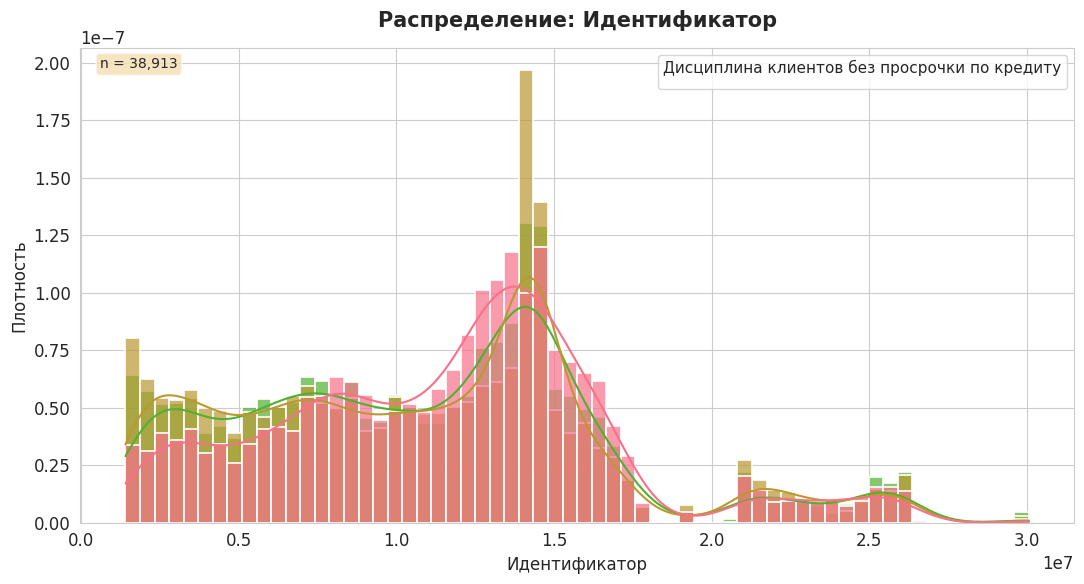

График построен: Идентификатор


/tmp/ipython-input-1136757009.py:21: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title=target_col, title_fontsize=11, fontsize=10, loc='upper right')


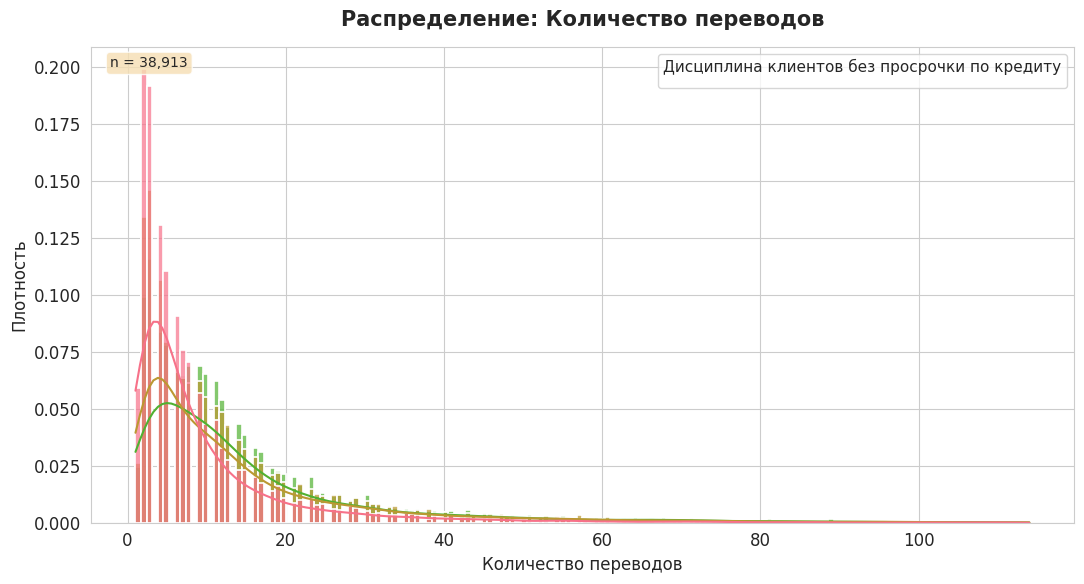

График построен: Количество переводов


/tmp/ipython-input-1136757009.py:21: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title=target_col, title_fontsize=11, fontsize=10, loc='upper right')


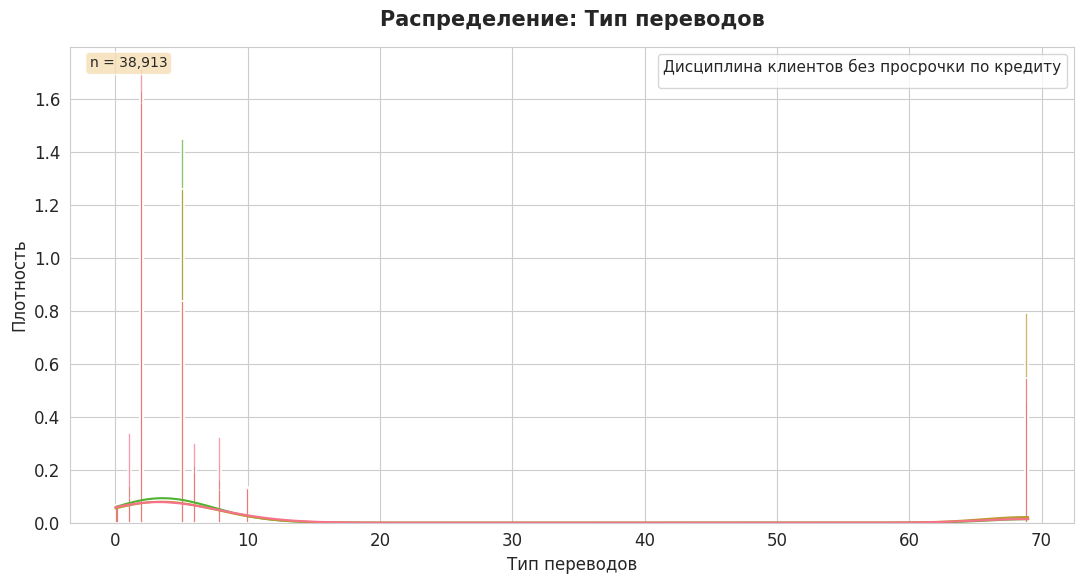

График построен: Тип переводов


/tmp/ipython-input-1136757009.py:21: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title=target_col, title_fontsize=11, fontsize=10, loc='upper right')


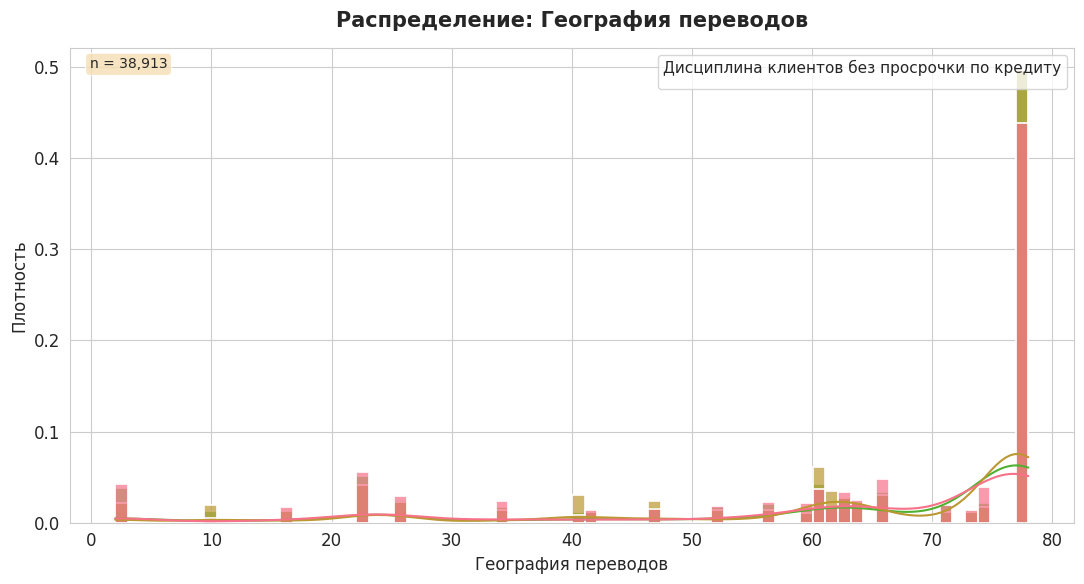

График построен: География переводов


/tmp/ipython-input-1136757009.py:21: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title=target_col, title_fontsize=11, fontsize=10, loc='upper right')


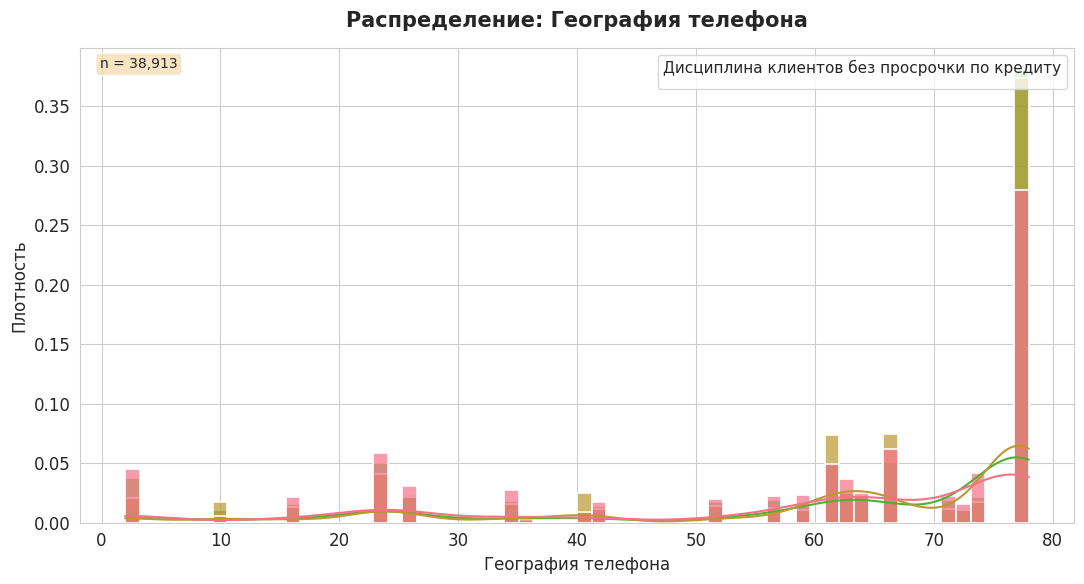

График построен: География телефона


/tmp/ipython-input-1136757009.py:21: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title=target_col, title_fontsize=11, fontsize=10, loc='upper right')


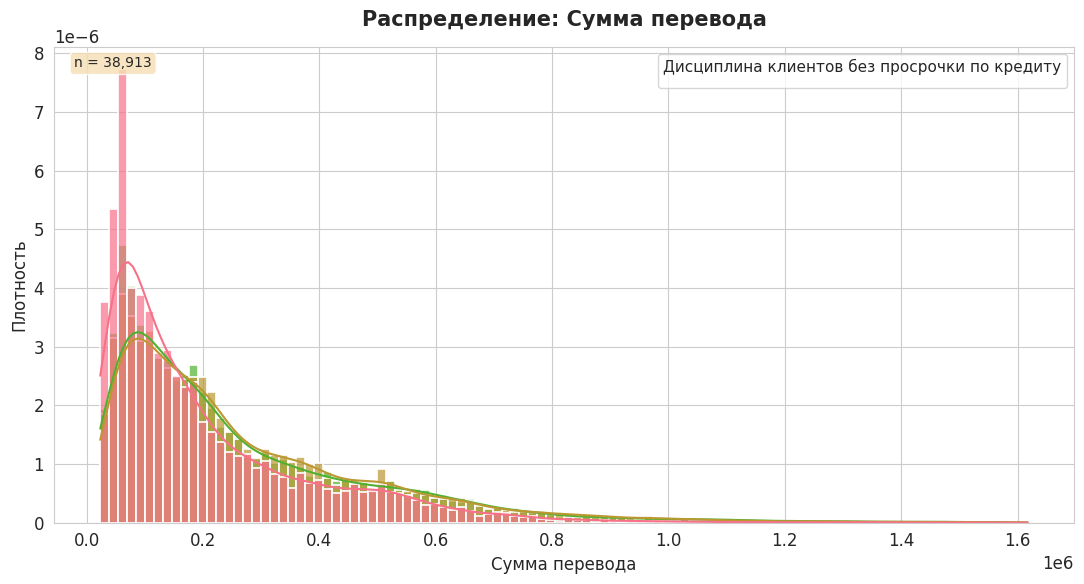

График построен: Сумма перевода


/tmp/ipython-input-1136757009.py:21: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title=target_col, title_fontsize=11, fontsize=10, loc='upper right')


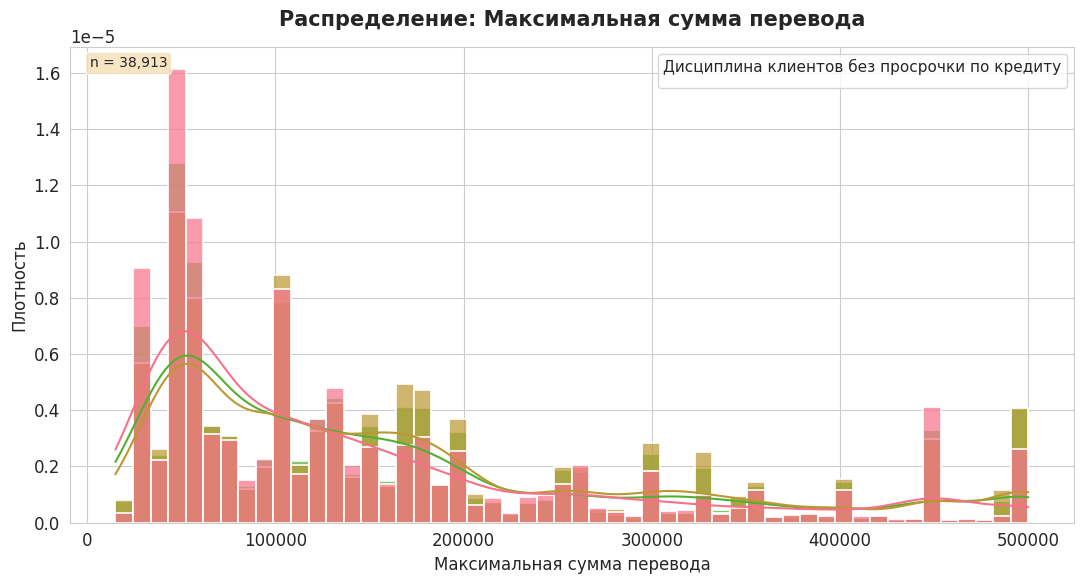

График построен: Максимальная сумма перевода


/tmp/ipython-input-1136757009.py:21: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title=target_col, title_fontsize=11, fontsize=10, loc='upper right')


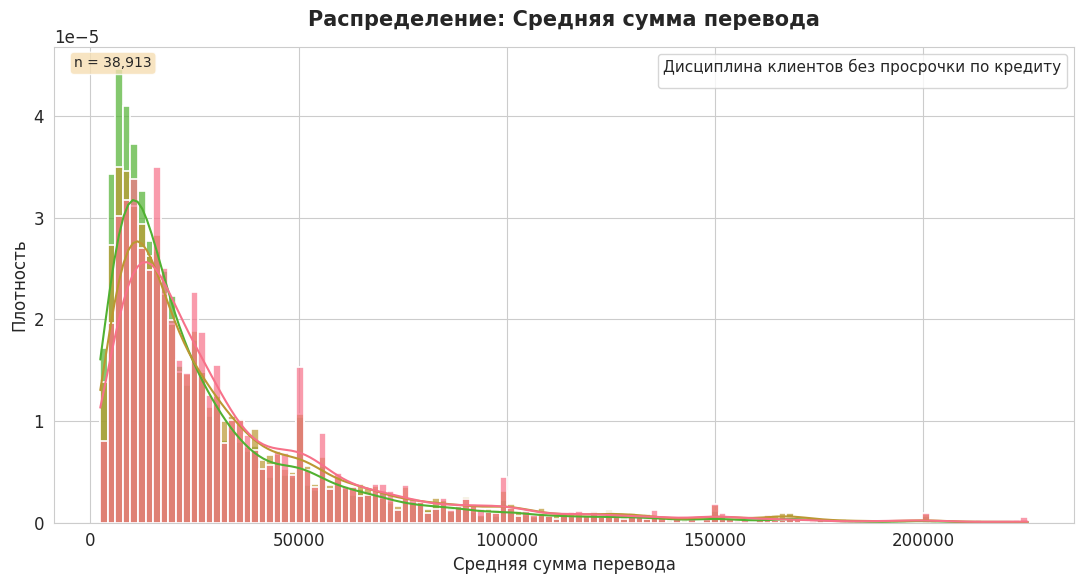

График построен: Средняя сумма перевода


/tmp/ipython-input-1136757009.py:21: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title=target_col, title_fontsize=11, fontsize=10, loc='upper right')


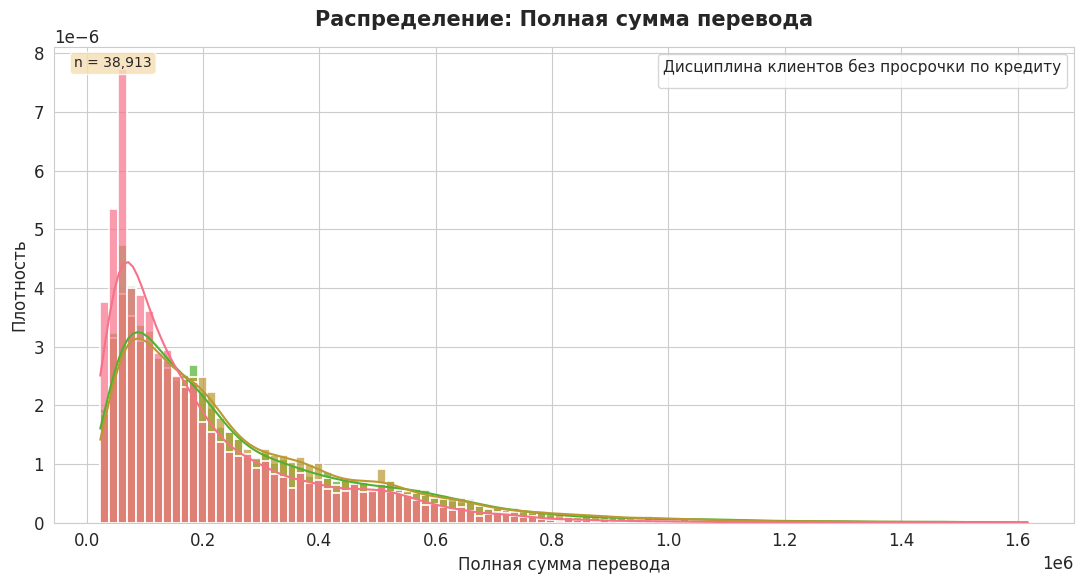

График построен: Полная сумма перевода


In [ ]:
print("1. ВИЗУАЛИЗАЦИЯ ЧИСЛОВЫХ ПРИЗНАКОВ".center(60, " "))
print("=" * 60)

for col in numerical_cols:
    plt.figure(figsize=(11, 6))

    sns.histplot(
        data=df_clean,
        x=col,
        hue=target_col,
        kde=True,
        alpha=0.7,
        stat='density',
        common_norm=False,
        linewidth=1.2
    )

    plt.title(f'Распределение: {col}', fontsize=15, pad=15, fontweight='bold')
    plt.xlabel(col, fontsize=12)
    plt.ylabel('Плотность', fontsize=12)
    plt.legend(title=target_col, title_fontsize=11, fontsize=10, loc='upper right')

    # Добавляем статистику
    stats_text = f"n = {len(df_clean):,}"
    plt.text(0.02, 0.98, stats_text, transform=plt.gca().transAxes,
             fontsize=10, verticalalignment='top',
             bbox=dict(boxstyle="round", facecolor='wheat', alpha=0.8))

    plt.tight_layout()
    plt.show()
    print(f"График построен: {col}")

         
2. ВИЗУАЛИЗАЦИЯ КАТЕГОРИАЛЬНЫХ ПРИЗНАКОВ          


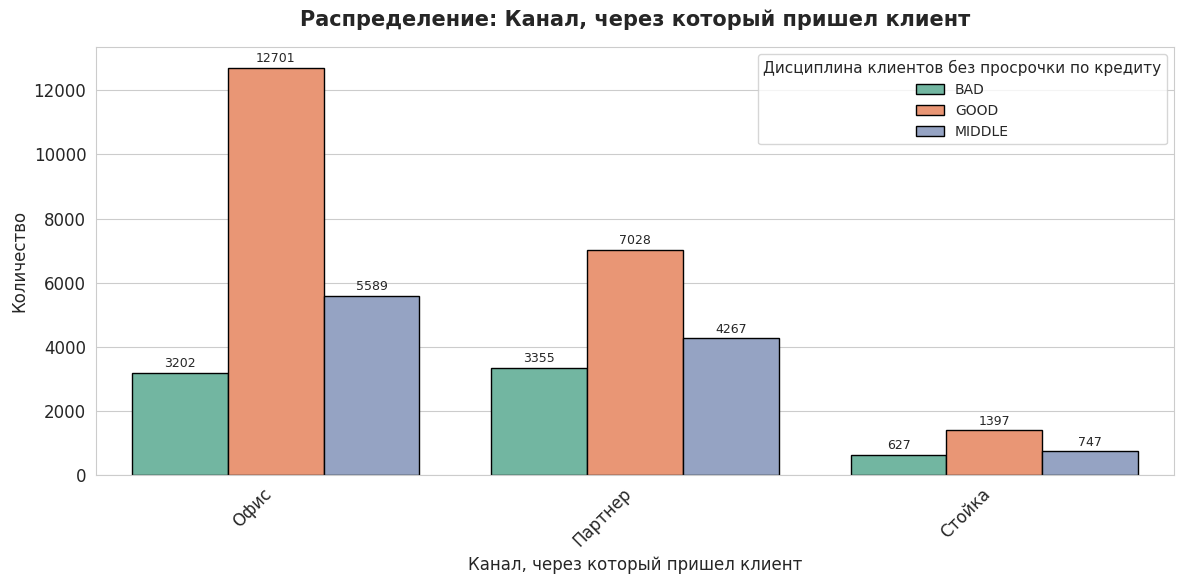

График построен: Канал, через который пришел клиент


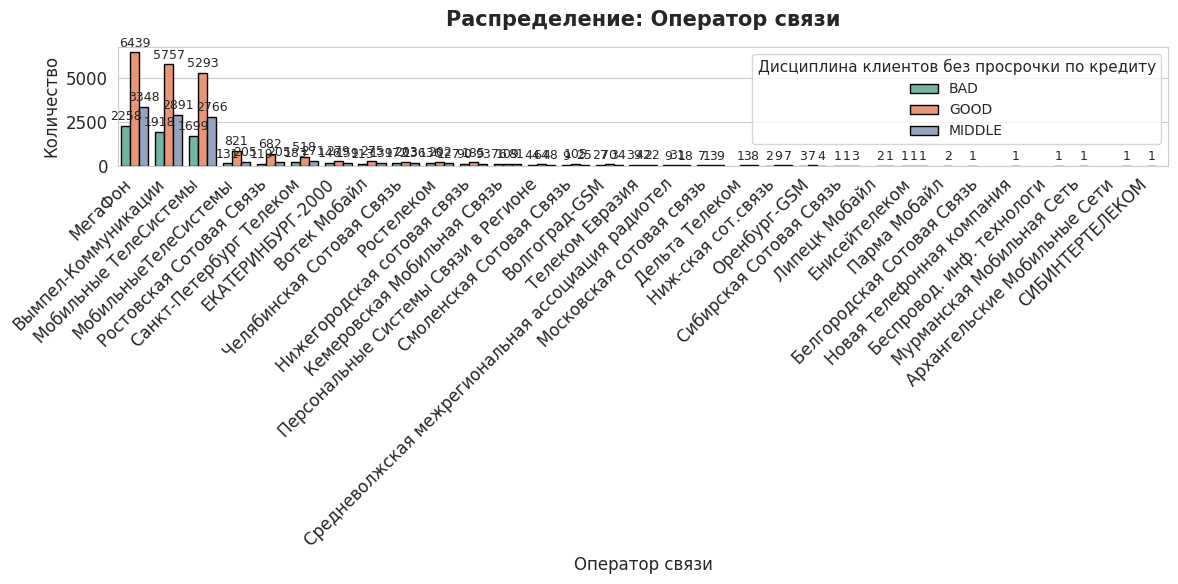

График построен: Оператор связи


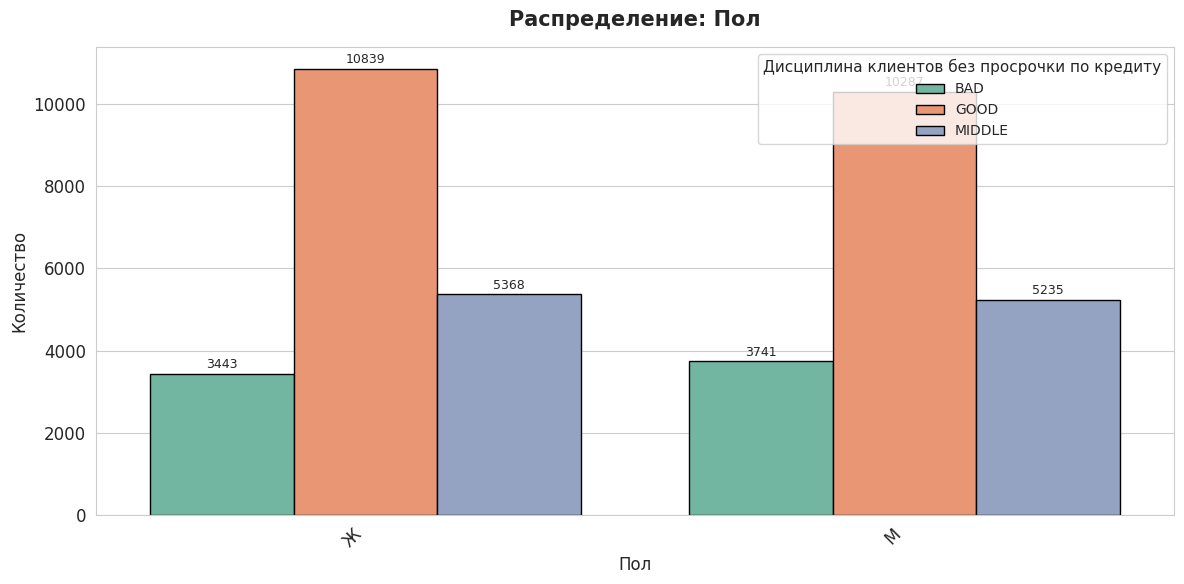

График построен: Пол


In [ ]:
print("\n2. ВИЗУАЛИЗАЦИЯ КАТЕГОРИАЛЬНЫХ ПРИЗНАКОВ".center(60, " "))
print("=" * 60)

for col in categorical_cols:
    plt.figure(figsize=(12, 6))

    # Сортировка по частоте
    order = df_clean[col].value_counts().index

    ax = sns.countplot(
        data=df_clean,
        x=col,
        hue=target_col,
        order=order,
        palette='Set2',
        edgecolor='black',
        linewidth=1
    )

    plt.title(f'Распределение: {col}', fontsize=15, pad=15, fontweight='bold')
    plt.xlabel(col, fontsize=12)
    plt.ylabel('Количество', fontsize=12)
    plt.legend(title=target_col, title_fontsize=11, fontsize=10)
    plt.xticks(rotation=45, ha='right')

    # Подписи значений над столбцами
    for container in ax.containers:
        ax.bar_label(container, fontsize=9, padding=2)

    plt.tight_layout()
    plt.show()
    print(f"График построен: {col}")

**Портрет клиента GOOD (благонадёжный)**
Числовые признаки
Высокая активность по переводам: в среднем совершают больше транзакций, особенно у части клиентов с очень большим числом операций (до 100+ переводов).
Высокие суммы переводов:
Средняя сумма перевода — значительно выше, чем у BAD/MIDDLE.
Полная сумма переводов часто достигает сотен тысяч и миллионов рублей.
Стабильные транзакции: низкий разброс между средней и максимальной суммой — признак регулярности и предсказуемости.
Возраст: чаще встречается в более зрелых возрастных группах (40–70 лет).
Категориальные признаки
Канал привлечения: преобладает «Офис» — клиенты приходят лично, что может говорить о более тщательной проверке и вовлечённости.
Операторы связи: в основном крупные федеральные операторы — МТС, МегаФон, Вымпел-Коммуникации.
География: часто 77 (Москва), 61, 62 (Ростовская область), 78 (Санкт-Петербург) — крупные экономически активные регионы.
Итог: GOOD-клиент — финансово активный, стабильный, из крупных городов, пользуется услугами крупных операторов, взаимодействует с банком лично.

**Портрет клиента BAD (неблагонадёжный)**
Числовые признаки
Низкая или нерегулярная активность: часто всего 1–3 перевода, но иногда — очень крупные разовые операции (возможно, попытка «замаскировать» финансовую нестабильность).
Поляризация сумм:
Либо очень низкие суммы (до нескольких тысяч),
Либо единичные крупные переводы (без регулярности).
Высокий разброс между средней и максимальной суммой — признак непредсказуемости.
Возраст: встречается во всех группах, но есть доля молодых клиентов (до 35 лет) и пожилых (после 70).
Категориальные признаки
Канал привлечения: чаще «Партнер» или «Стойка» — менее контролируемые точки продаж.
Операторы связи: кроме федеральных, часто встречаются региональные операторы («Ростовская Сотовая Связь», «Вотек Мобайл», «ЕКАТЕРИНБУРГ-2000»).
География: более разнообразная, включая малые регионы (коды 0, 2, 18, 34 и др.), что может указывать на меньшую финансовую устойчивость.
Итог: BAD-клиент — менее предсказуемый, часто привлекается через сторонние каналы, использует региональные операторы, демонстрирует либо низкую, либо спорадическую активность.

**Портрет клиента MIDDLE (промежуточный)**
По активности и суммам находится между GOOD и BAD, но ближе к GOOD.
Умеренное число переводов (в среднем 5–15).
Суммы — ниже, чем у GOOD, но более стабильны, чем у BAD.
География и операторы — смешанные: и федеральные, и региональные.
Каналы: как «Офис», так и «Партнер» — сбалансированное распределение.
Итог: MIDDLE-клиент — потенциально улучшаемая категория. При правильной работе (например, перевод в премиум-сегмент через офлайн-коммуникации) может стать надёжным плательщиком.


*Клиенты из офиса — наиболее благонадёжные. Стоит ограничить или усиливать проверку по каналам «Партнер» и «Стойка».
Клиенты из регионов с кодами 0, 2, 18, 34, 54 и др. чаще попадают в BAD. Это можно использовать в скоринговых моделях.
Активность = надёжность:
Чем стабильнее и выше активность по переводам, тем ниже вероятность просрочки. Стоит поощрять регулярные операции (кэшбэк, бонусы).
Оператор связи — косвенный признак уровня дохода:
Пользователи федеральных операторов (МТС, МегаФон, Билайн) надёжнее.
Разовые крупные платежи — тревожный сигнал:
Если клиент совершил 1–2 крупных перевода и исчез — это риск.*
